In [440]:
import umap
import math
import numpy as np
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.decomposition import DictionaryLearning
from scipy.stats import binom_test

import matplotlib.pyplot as plt

import matplotlib.image as mpimg
import seaborn as sns

from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_predict

from contrastive.evaluation.train_multiple_classifiers import compute_auc

In [394]:
# test model
test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/contrastive/trained_on_HCP_half_2/all/foldlabel/convnet-10/09-21-24_1"
# test_model = "/neurospin/dico/data/deep_folding/papers/ipmi2023/models/beta-VAE/n_10/#2"
dataset = 'cingulate_ACCpatterns_1'

# load the data
data_df = pd.read_csv(test_model+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
data_df.sort_index(inplace=True)

# load the labels
prediction_df = pd.read_csv(test_model+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
prediction_df.sort_index(inplace=True)

## UMAP

In [3]:
def get_model_by_quality(labels_df, q=0.5):
    aucs = labels_df.apply(compute_auc, args=[labels_df.label])
    aucs = aucs[aucs.index != 'label']
    model_auc = aucs.quantile(q=q, interpolation='nearest')
    aucs = aucs[aucs == model_auc]
    return(aucs.index[0], model_auc)

In [4]:
def visualize_umaps(model_path, quantiles=[0,0.5,1], thresholds=[0.25,0.5,0.75], show_wrong_class=False, dataset='cingulate_ACCpatterns_1', verbose=False):
    # load the data
    data_df = pd.read_csv(model_path+'/' + dataset + "_embeddings/full_embeddings.csv", index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path + '/' + dataset + "_embeddings/cross_val_predicted_labels.csv", index_col=0)
    prediction_df.sort_index(inplace=True)
    
    if verbose:
        print("Data df:")
        print(data_df[:5])
        print("Prediction df:")
        print(prediction_df[:5])

    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(visual_embs.shape)
        print(visual_embs[:5])
        
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels")
    plt.show()
    
    # plot for predicted labels
    n_i = len(quantiles)
    n_j = len(thresholds)
    plt.figure(figsize=(n_i*6.4, n_j*4.8))
    for i,quantile in enumerate(quantiles):
        svm_model, model_auc = get_model_by_quality(prediction_df, q=quantile)
        model_auc = "{:.2f}".format(model_auc)
        if verbose:
            print(f"Chosen svm model for quantile {quantile} (ie auc={model_auc}):")
        
        for j,threshold in enumerate(thresholds):
            plt.subplot(n_i, n_j, i*n_j + j + 1)
            
            mid_svm_pred = (prediction_df[svm_model] >= threshold).astype(int)
            if verbose:
                print(mid_svm_pred[:5])
                print("shape:", mid_svm_pred.shape)

            colors = [cmap[i] for i in mid_svm_pred]
            if show_wrong_class:
                colors = []
                # for i in range(prediction_df.shape[0]):
                #     if prediction_df[la]

            plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
            if i == n_i-1:
                plt.xlabel(f"Decision threshold = {threshold}")
            if j == 0:
                plt.ylabel(f"Model quality={quantile} (auc={model_auc})")
            # compute accuracy
            accuracy = ((prediction_df[svm_model] >= threshold) == prediction_df.label).astype(float).mean()
            plt.title("Svm labels ; accuracy = {:.2f}".format(accuracy))
    plt.show()

    return pd.DataFrame(visual_embs, index=data_df.index.values)

In [5]:
def cross_correlation(model_path, dataset='cingulate_ACCpatterns_1'):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    fig, axs = plt.subplots(1, 4, figsize=(30,10)) 

    latent_df = full_df.iloc[:,1:]
    corr = latent_df.corr()
    axs[0] = sns.heatmap(
            corr, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[0]
            )

    latent_df = full_df[full_df.label == 0].iloc[:,1:]
    corr0 = latent_df.corr()
    axs[1] = sns.heatmap(
            corr0, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[1]
            )

    latent_df = full_df[full_df.label == 1].iloc[:,1:]
    corr1 = latent_df.corr()
    axs[2] = sns.heatmap(
            corr1, 
            vmin=-1, vmax=1, center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[2]
            )

    corrdiff = (corr1-corr0)
    axs[3] = sns.heatmap(
            corrdiff, 
            vmin=corrdiff.min().min(), vmax=corrdiff.max().max(), center=0,
            cmap=sns.diverging_palette(20, 220, n=200),
            square=True,
            ax=axs[3]
            )


In [6]:
def visualize_each_variable(model_path, display: str, display_err: bool, normalize=True, verbose=False, dataset='cingulate_ACCpatterns_1'):
    '''
    display: str -> takes the values '0', '1', 'all'
    '''
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Chooses to display only labels '0', '1' or all
    if display == '0':
        full_df = full_df[full_df.label == 0]
    elif display == '1':
        full_df = full_df[full_df.label == 1]
    
    # Some prints if verbose true
    if verbose:
        print("Prediction df:")
        print(prediction_df.iloc[:2, :2])
        print(len(prediction_df))
        print(prediction_df[['label']].shape)
        print("Data df:")
        print(len(data_df))
        print(data_df.iloc[:2, :2])
        print(data_df.shape)
        print("Full df:")
        print(len(full_df))
        print(full_df.iloc[:2, :2])
        print(full_df.shape)

    N, D = full_df.shape
    D = D-1 # There is the label column added

    # Initializes plot
    plt.figure(figsize=(16,12))

    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, N, axis=0)

    # Replaces labels 0, 1 with colors
    label_df = full_df[['label']].copy()
    label_df['label'] = label_df['label'].astype("str")
    label_df['label'] = label_df['label'].replace('0', 'b')
    label_df['label'] = label_df['label'].replace('1', 'r')

    # Builds colors to match pyplot requirements
    colors = label_df['label'].values
    colors = np.reshape(colors, (1,N))
    colors = np.repeat(colors, D, axis=0)
    colors = colors.T
    print('x, full_df and colors shapes: ', x.shape, full_df.shape, colors.shape)
    colors = np.reshape(colors, (N*D,))

    # latent (doesn't take the first column, which is the label)
    latent_df = full_df.iloc[:,1:]
    mu = latent_df.mean()
    std = latent_df.std()
    if normalize == True:
        latent_df = (latent_df-mu)/std

    # Actual plotting of each point
    plt.scatter(x, latent_df, c=colors, marker='.')

    # Computes averages
    if display == "all":
        # Computes average for label=0
        x = np.arange(D)
        label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
        if normalize == True:   
            label0_df = (label0_df-mu)/std
        mean_df = label0_df.mean()
        e_df = label0_df.std()
        print(x.shape, mean_df.shape, e_df.shape)
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='blue', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3, solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

        # Computes average for label=1
        label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
        if normalize == True:   
            label1_df = (label1_df-mu)/std
        mean_df = label1_df.mean()
        e_df = label1_df.std()
        if display_err:
            plt.errorbar(x, mean_df, yerr=e_df, color='red', linestyle='None', elinewidth=4, marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3,solid_capstyle='projecting', capsize=10)
        else:
            plt.plot(x, mean_df, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    # Shows the computed plot
    plt.show()

    return 

In [7]:
def full_visualization(model_path, dataset='cingulate_ACCpatterns_1'):
    plt.figure(figsize=(12.8, 9.6))
    fig = plt.imshow(mpimg.imread(model_path+"/"+dataset+"_embeddings/cross_val_ROC_curves.png"))
    plt.axis('off')
    plt.show()
    return visualize_umaps(model_path, dataset)

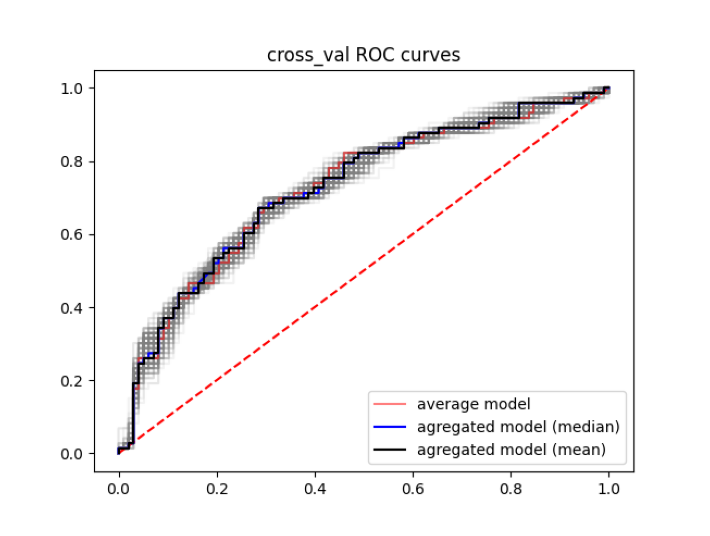

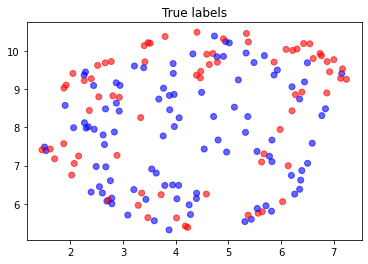

TypeError: '<=' not supported between instances of 'int' and 'numpy.ndarray'

<Figure size 10598.4x1036.8 with 0 Axes>

In [8]:
# test model
visual_embs = full_visualization(test_model)

# Visualize each variable of the latent

x, full_df and colors shapes:  (171, 10) (171, 11) (171, 10)
(10,) (10,) (10,)


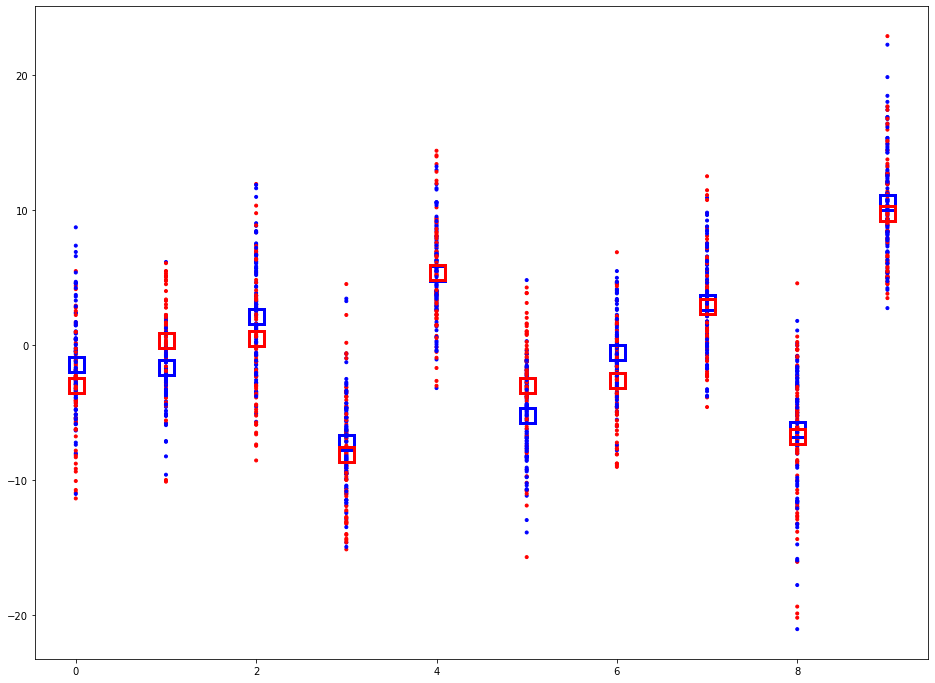

In [408]:
visualize_each_variable(test_model, display='all', display_err=False, normalize=False, verbose=False)

In [409]:
def do_pca(model_path, dataset=dataset):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = latent_df.shape[1]
    pca = PCA(n_components=n_components)
    transformed = pca.fit_transform(latent_df_normalized)

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = pca.transform(label0_df)
    mean0 = np.mean(transformed0, axis=0)
    print(mean0.shape)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = pca.transform(label1_df)
    mean1 = np.mean(transformed1, axis=0)
    print(mean1.shape)

    idx = np.arange(n_components)+1
    explained_variance = pca.explained_variance_ratio_
    cum_explained_variance = np.cumsum(explained_variance)
    df_explained_variance = pd.DataFrame([explained_variance, cum_explained_variance], 
                                     index=['explained variance', 'cumulative'], 
                                     columns=idx).T

    limit_df = n_components

    #make scree plot
    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    fig, axs = plt.subplots(1, 2, figsize=(30,10)) 
    [t.set_color('white') for t in axs[0].xaxis.get_ticklabels()]
    [t.set_color('white') for t in axs[0].yaxis.get_ticklabels()]
    axs[0].set_title('Explained variance across principal components', fontsize=14)
    axs[0].set_xlabel('Principal component', fontsize=12)
    axs[0].set_ylabel('Explained variance', fontsize=12)
    sns.barplot(ax=axs[0], x=idx[:limit_df], y='explained variance', data=df_explained_variance, palette='summer')
    axs[0] = axs[0].twinx()
    axs[0].grid(False)
    axs[0].set_ylabel('Cumulative', fontsize=14)
    sns.lineplot(ax=axs[0], x=idx[:limit_df]-1, y='cumulative', data=df_explained_variance, color='#fc8d59')

    N, D = transformed.shape
    # Builds x coordinates for scatter plot
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs[1].scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs[1].scatter(x, transformed1, c='red', marker='.')
    x = np.arange(D)
    axs[1].plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)
    axs[1].plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()


In [400]:
def do_dictionary_learning(data_df, n_components=10, transform_n_nonzero_coefs=1):
    data_df_local = data_df.copy()
    full_df_local = pd.DataFrame()
    # Makes dictionary learning over all embeddings
    latent_df = data_df_local.iloc[:,:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components,
                                      transform_n_nonzero_coefs=transform_n_nonzero_coefs,
                                      alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df_local = pd.DataFrame(transformed, columns=columns)
    transformed_df_local.index = data_df_local.index
    full_df_local = pd.merge(data_df_local, transformed_df_local, left_index=True, right_index=True)

    return full_df_local, transformed_df_local, dict_learner

In [397]:
def plot_patterns(prediction_df, transformed_df, random=False):
    # Makes local copy
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)
    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Transforms over label0 dataframe
    label0_df = full_df_local[full_df_local['label'] == 0].iloc[:,1:]
    transformed0 = label0_df.values

    # Transforms over label1 dataframe
    label1_df = full_df_local[full_df_local['label'] == 1].iloc[:,1:]
    transformed1 = label1_df.values

    fig, axs = plt.subplots(1, 1, figsize=(10,7)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

In [398]:
def return_predictions(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res = np.zeros(2*n_patterns)

    # Makes random permutation to produce random label
    if random:
        prediction_df_local['label'] = np.random.permutation(prediction_df_local['label'].values)

    full_df_local = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df_local[full_df_local[c] > 0.]
        res[2*i] = df['label'].mean()
        df = full_df_local[full_df_local[c] < 0.]
        res[2*i+1] = df['label'].mean()

    return res

def plot_predictions(prediction_df, transformed_df):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_random = np.zeros((20, 2*n_patterns))

    # Loads labels
    mean_label = prediction_df_local['label'].mean()
    print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res = return_predictions(prediction_df_local, transformed_df_local)
    for i in range(20):
        res_random[i,:] = return_predictions(prediction_df_local, transformed_df_local, True)
    
    for i in range(20):
        plt.scatter(x, res_random[i], c='grey')

    plt.scatter(x, res, c='red')
    plt.plot(mean_label*np.ones(2*n_patterns))

    return res   

In [613]:
def return_sum(prediction_df, transformed_df, random=False):
    # Initializes
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    res_sum = np.zeros(2*n_patterns)
    res_len = np.zeros(2*n_patterns)

    full_df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)

    # Makes prediction for each pattern
    for i, c in enumerate(transformed_df_local.columns):
        df = full_df[full_df[c] > 0.]
        res_sum[2*i] = df['label'].sum()
        res_len[2*i] = len(df)
        df = full_df[full_df[c] < 0.]
        res_sum[2*i+1] = df['label'].sum()
        res_len[2*i+1] = len(df)

    return res_sum, res_len


def do_t_test(prediction_df, transformed_df, show=True):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()
    n_patterns = len(transformed_df_local.columns)
    x = np.arange(2*n_patterns)
    res_p = np.zeros(2*n_patterns)

    # Mean labels
    mean_label = prediction_df_local['label'].mean()
    # print(f"Mean label = {mean_label}")

    # Computes pattern prediction
    res_sum, res_len = return_sum(prediction_df_local, transformed_df_local)
    
    for i in range(2*n_patterns):
        res_p[i] = binom_test(res_sum[i], n=res_len[i], p=0.5, alternative='two-sided')

    if show:
        plt.scatter(x, res_p)
        plt.plot(0.05*np.ones(2*n_patterns))
        plt.yscale('log')

    return res_p   

In [698]:
def give_number_relevant_subjects(prediction_df, transformed_df, res_p, show=True):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)
    nb_subjects = np.zeros(len(res_p))
    nb_subjects_relevant = 0
    max_auc_score = 0.0
    auc_score = np.zeros(len(res_p))
    # print(len(df.columns))
    for i in range(1,len(df.columns)):
        # print(df.iloc[:,[i]].columns)
        d = df[df.iloc[:,i] > 0.]
        d = d.copy()
        if d.label.sum() < (len(d.label)/2.):
            d.iloc[:,i] = -d.iloc[:,i]
        d.iloc[:,i] = 1. / (1. + np.exp(d.iloc[:,i]))
        # print(np.unique(d.label.values).shape)
        nb_subjects[2*i-2] = len(d)
        if len(np.unique(d.label.values)) == 1:
            d.iloc[0,0] = 1-d.iloc[0,0]
            # auc_score[2*i-2] = 1.0
            # print(i, len(d), res_p[2*i-2], 1.0)
        # else:
        #     auc_score[2*i-2] = roc_auc_score(d.label, d.iloc[:,i])
            # print(i, len(d), res_p[2*i-2], roc_auc_score(d.label, d.iloc[:,i]))
        auc_score[2*i-2] = roc_auc_score(d.label, d.iloc[:,i])
        # auc_score[2*i-2] = roc_auc_score(d.label, d.iloc[:,i])
        if res_p[2*i-2] < 0.01:
            nb_subjects_relevant += nb_subjects[2*i-2]
            max_auc_score = max(auc_score[2*i-2], max_auc_score)

        d = df[df.iloc[:,i] < 0.]
        d = d.copy()
        if d.label.sum() >= (len(d.label)/2.):
            d.iloc[:,i] = -d.iloc[:,i]
        d.iloc[:,i] = 1. / (1. + np.exp(d.iloc[:,i]))
        nb_subjects[2*i-1] = len(d)
        if len(np.unique(d.label.values)) == 1:
            d.iloc[0,0] = 1-d.iloc[0,0]
        auc_score[2*i-1] = roc_auc_score(d.label, d.iloc[:,i])
        if res_p[2*i-1] < 0.01:
            nb_subjects_relevant += nb_subjects[2*i-1]
            max_auc_score = max(auc_score[2*i-1], max_auc_score)
            
    # print(d)
    if show:
        x = np.arange(len(res_p))
        plt.scatter(x, auc_score)
        plt.ylabel('auc_score')
        # plt.scatter(res_p, auc_score)
        # plt.xlabel('p value')
        # plt.ylabel('auc_score')
    return nb_subjects_relevant, max_auc_score

In [717]:
def give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, show=True):
    prediction_df_local = prediction_df.copy()
    transformed_df_local = transformed_df.copy()

    df = pd.merge(prediction_df_local[['label']], transformed_df_local, left_index=True, right_index=True)
    nb_subjects = np.zeros(len(res_p))
    nb_subjects_relevant = 0
    max_auc_score = 0.0
    auc_score = np.zeros(len(res_p))
    # print(len(df.columns))
    for i in range(1,len(df.columns)):
        # print(df.iloc[:,[i]].columns)
        d = df[df.iloc[:,i] > 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        # print(np.unique(d.label.values).shape)
        nb_subjects[2*i-2] = len(d)
        auc_score[2*i-2] = accuracy_score(d.label, d.iloc[:,i])
        if res_p[2*i-2] < 0.01:
            nb_subjects_relevant += nb_subjects[2*i-2]
            max_auc_score = max(auc_score[2*i-2], max_auc_score)

        d = df[df.iloc[:,i] < 0.]
        d = d.copy()
        if 2.*d.label.sum() < (len(d.label)):
            d.iloc[:,i] = 0
        else:
            d.iloc[:,i] = 1
        nb_subjects[2*i-1] = len(d)
        auc_score[2*i-1] = accuracy_score(d.label, d.iloc[:,i])
        if res_p[2*i-1] < 0.01:
            nb_subjects_relevant += nb_subjects[2*i-1]
            max_auc_score = max(auc_score[2*i-1], max_auc_score)
            
    # print(d)
    if show:
        x = np.arange(len(res_p))
        plt.scatter(x, auc_score)
        plt.ylabel('auc_score')
        # plt.scatter(res_p, auc_score)
        # plt.xlabel('p value')
        # plt.ylabel('auc_score')
    return nb_subjects_relevant, max_auc_score

In [718]:
full_df, transformed_df, dict_learner = do_dictionary_learning(data_df=data_df, n_components=6)

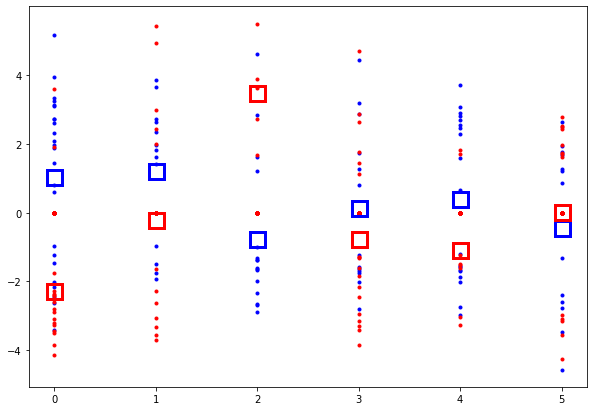

In [719]:
plot_patterns(prediction_df, transformed_df, random=False)

In [708]:
# plot_patterns(prediction_df, transformed_df, random=True)

Mean label = 0.4269005847953216


array([0.11111111, 0.65217391, 0.35714286, 0.63636364, 0.55555556,
       0.        , 0.5       , 0.63157895, 0.16666667, 0.4       ,
       0.53333333, 0.45454545])

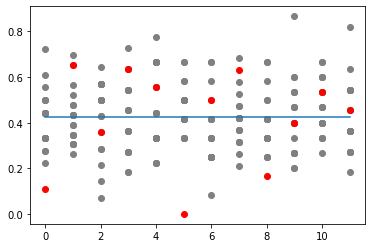

In [710]:
plot_predictions(prediction_df, transformed_df)

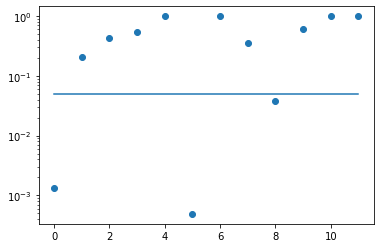

In [720]:
res_p = do_t_test(prediction_df, transformed_df)

(30.0, 1.0)

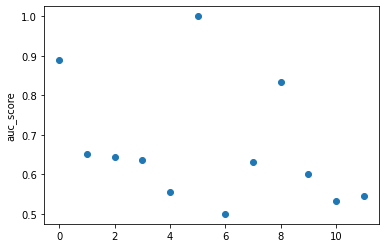

In [721]:
give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p)

In [726]:
list_components = [1,2,3,4,5,6,7,8,9,10]
list_nb_relevant_subjects = []
list_max_auc_score = []
list_min_p = []
for n_components in list_components:
    full_df, transformed_df, dict_learner = \
        do_dictionary_learning(data_df=data_df, n_components=n_components)
    res_p = do_t_test(prediction_df, transformed_df, show=False)
    nb_subjects, max_auc = give_number_relevant_subjects_accuracy(prediction_df, transformed_df, res_p, False)
    list_nb_relevant_subjects.append(nb_subjects)
    list_max_auc_score.append(max_auc)
    list_min_p.append(min(res_p))
    print(f"component {n_components}: done")

component 1: done
component 2: done
component 3: done
component 4: done
component 5: done
component 6: done
component 7: done
component 8: done
component 9: done
component 10: done


Text(0, 0.5, 'Proportion well-classified subjects')

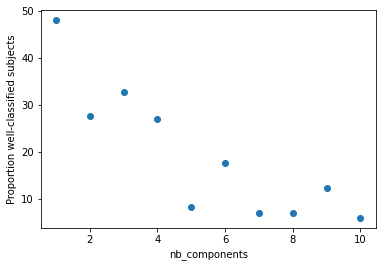

In [727]:
plt.scatter(list_components, np.array(list_nb_relevant_subjects)/len(data_df)*100.)
plt.xlabel('nb_components')
plt.ylabel('Proportion well-classified subjects')

Text(0, 0.5, 'Max accuracy when relevant')

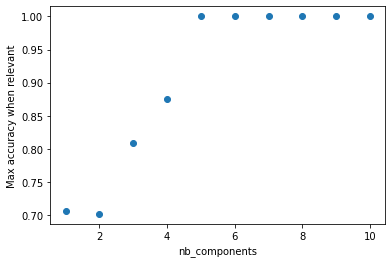

In [728]:
plt.scatter(list_components, list_max_auc_score)
plt.xlabel('nb_components')
plt.ylabel('Max accuracy when relevant')

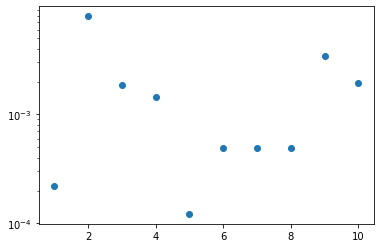

In [731]:
plt.scatter(list_components, list_min_p)
plt.yscale('log')

Text(0, 0.5, 'Max accuracy when relevant')

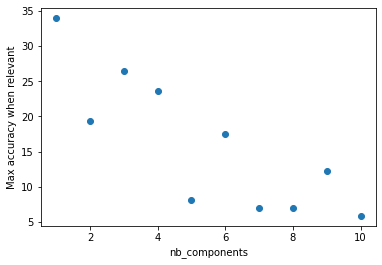

In [732]:
plt.scatter(list_components, np.array(list_max_auc_score)*np.array(list_nb_relevant_subjects)/len(data_df)*100.)
plt.xlabel('nb_components')
plt.ylabel('Max accuracy when relevant')

In [716]:
accuracy_score([1,1,1], [1,1,1])

1.0

## Old dictionary learning

In [590]:
def do_dictionary_learning_old(model_path, dataset=dataset, n_components=10, random=False):
    # load the data
    data_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
    data_df.sort_index(inplace=True)

    prediction_df = pd.read_csv(model_path+'/'+dataset+'_embeddings/cross_val_predicted_labels.csv', index_col=0)
    prediction_df.sort_index(inplace=True)
    if random:
        prediction_df['label'] = np.random.permutation(prediction_df['label'].values)

    full_df = pd.merge(prediction_df[['label']], data_df, left_index=True, right_index=True)
    print(full_df.head())

    # Makes PCA over all dataframe
    latent_df = full_df.iloc[:,1:]
    latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
    n_components = n_components
    dict_learner = DictionaryLearning(n_components=n_components, alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)

    # Adds transform to full_df
    columns = ['trans_'+str(x) for x in range(n_components)]
    transformed_df = pd.DataFrame(transformed, columns=columns)
    transformed_df.index = full_df.index
    full_df1 = pd.merge(full_df, transformed_df, left_index=True, right_index=True)
    print(full_df1.iloc[:,10:].head())

    # Transforms over label0 dataframe
    label0_df = full_df[full_df['label'] == 0].iloc[:,1:]
    label0_df = (label0_df - latent_df.mean()) / latent_df.std()
    transformed0 = dict_learner.transform(label0_df)

    # Transforms over label1 dataframe
    label1_df = full_df[full_df['label'] == 1].iloc[:,1:]
    label1_df = (label1_df - latent_df.mean()) / latent_df.std()
    transformed1 = dict_learner.transform(label1_df)

    fig, axs = plt.subplots(1, 1, figsize=(10,7)) 

    _, D = transformed0.shape

    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed0.shape[0], axis=0)
    axs.scatter(x, transformed0, c='blue', marker='.')
    x = np.reshape(np.arange(D), (1,D))
    x = np.repeat(x, transformed1.shape[0], axis=0)
    axs.scatter(x, transformed1, c='red', marker='.')

    x = np.arange(D)

    masked0 = np.ma.masked_equal(transformed0, 0.)
    mean0 = masked0.mean(axis=0)
    axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    masked1 = np.ma.masked_equal(transformed1, 0.)
    mean1 = masked1.mean(axis=0)
    axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

    plt.show()

    return transformed0, transformed1, transformed, latent_df_normalized.values, dict_learner


              label      dim1      dim2       dim3       dim4       dim5  \
Subject                                                                    
1-20FORHU_t0      0 -3.123060  6.168192  10.994134 -12.896856  12.988349   
1-23CREES_t0      0 -3.204141  0.930524  -3.443141  -4.672270   0.197939   
2-02FERMA_t0      1 -2.552280 -4.165613   7.548296  -9.103716   7.979238   
2-04HEBTO_t0      0 -4.096864 -0.429451   1.279251  -8.081337   3.803484   
2-08BESAG_t0      0  7.379445  0.991153  -0.754005  -9.944673   8.469857   

                   dim6      dim7      dim8       dim9      dim10  
Subject                                                            
1-20FORHU_t0  -1.144557 -1.556553  5.567920  -4.038709  19.871367  
1-23CREES_t0   4.827088 -6.005972 -0.225557 -13.293138  10.211520  
2-02FERMA_t0 -11.155951  4.085872  5.350001  -6.082886  15.350778  
2-04HEBTO_t0  -0.906266 -3.713860  0.172554  -7.247314   9.348074  
2-08BESAG_t0  -5.265257  0.527065 -1.535072 -10.101777  12.

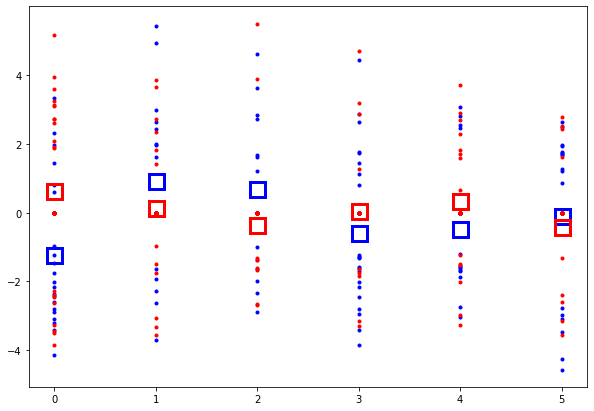

In [278]:
transformed0, transformed1, transformed, X, dict_learner = do_dictionary_learning(test_model, n_components=6, random=True)

In [267]:
type(transformed)

numpy.ndarray

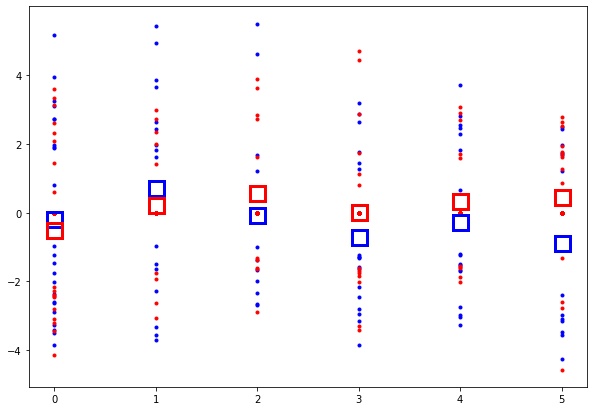

In [263]:
transformed0, transformed1, transformed, X, dict_learner = do_dictionary_learning(test_model, n_components=6, random=False)

In [206]:
print(f"sparsity = {np.mean(transformed == 0)}")
X_hat = transformed @ dict_learner.components_
print(f"reconstruction error = {np.mean(np.sum((X_hat - X) ** 2, axis=1) / np.sum(X ** 2, axis=1))}")

sparsity = 0.9
reconstruction error = 0.3163043786134237


In [40]:
print(transformed[0])
len(transformed)

[0.        0.        4.5803416 0.       ]


171

In [19]:
data_df = pd.read_csv(test_model+'/cingulate_ACCpatterns_1_embeddings/full_embeddings.csv', index_col=0)
data_df.sort_index(inplace=True)

print(transformed.shape)
print(data_df.head().iloc[:,0:5])

(171, 4)
                  dim1      dim2       dim3       dim4       dim5
ID                                                               
1-20FORHU_t0 -3.123060  6.168192  10.994134 -12.896856  12.988349
1-23CREES_t0 -3.204141  0.930524  -3.443141  -4.672270   0.197939
2-02FERMA_t0 -2.552280 -4.165613   7.548296  -9.103716   7.979238
2-04HEBTO_t0 -4.096864 -0.429451   1.279251  -8.081337   3.803484
2-08BESAG_t0  7.379445  0.991153  -0.754005  -9.944673   8.469857


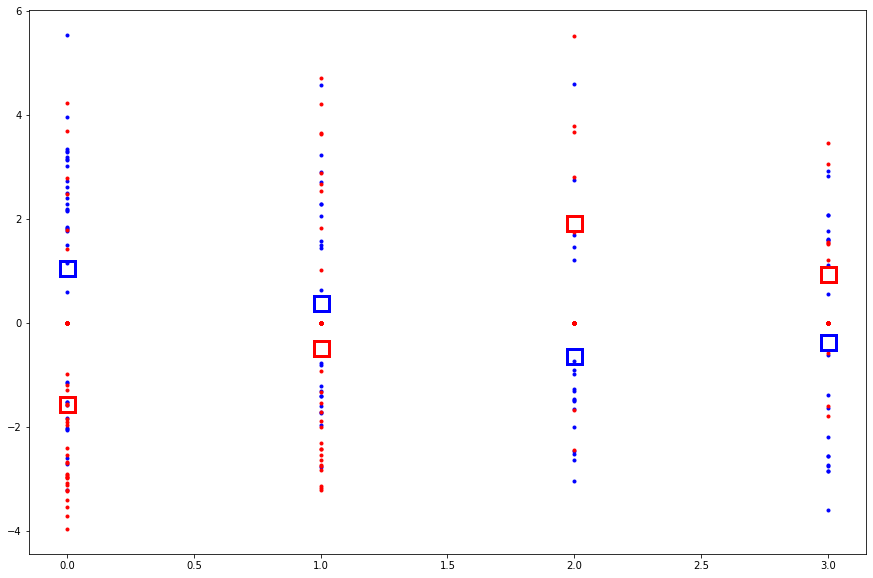

In [163]:
fig, axs = plt.subplots(1, 1, figsize=(15,10)) 

_, D = transformed0.shape

x = np.reshape(np.arange(D), (1,D))
x = np.repeat(x, transformed0.shape[0], axis=0)
axs.scatter(x, transformed0, c='blue', marker='.')
x = np.reshape(np.arange(D), (1,D))
x = np.repeat(x, transformed1.shape[0], axis=0)
axs.scatter(x, transformed1, c='red', marker='.')

x = np.arange(D)

masked0 = np.ma.masked_equal(transformed0, 0.)
mean0 = masked0.mean(axis=0)
axs.plot(x, mean0, color='blue', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

masked1 = np.ma.masked_equal(transformed1, 0.)
mean1 = masked1.mean(axis=0)
axs.plot(x, mean1, color='red', linestyle='None', marker='s', markersize=15, markerfacecolor='None', markeredgewidth=3)

plt.show()


In [164]:
def do_umap(model_path, dataset='cingulate_ACCpatterns_1', verbose=False):
    # load the data
    data_df = pd.read_csv(model_path+'/' + dataset + "_embeddings/full_embeddings.csv", index_col=0)
    data_df.sort_index(inplace=True)  

    # apply umap
    reducer = umap.UMAP()
    visual_embs = reducer.fit_transform(data_df)
    if verbose:
        print("UMAP embeddings")
        print(visual_embs.shape)
        print(visual_embs[:5])
    return visual_embs

In [165]:
visual_embs = do_umap(test_model)

In [166]:
def visualize_umaps_with_dict(visual_embs, transformed, y=1, verbose=False):
        
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'grey', 'r']
    transformed_local = transformed.copy()
    arr = transformed_local[:,y]
    if verbose:
        print(arr)
    arr[arr>0] = 2
    arr[arr==0] = 1
    arr[arr<0] = 0
    arr = arr.astype(int)
    if verbose:
        print(arr)
    colors = [cmap[l] for l in arr]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title(f"Pattern number {y}")
    plt.show()

In [167]:
prediction_df = pd.read_csv(test_model + '/' + dataset + "_embeddings/cross_val_predicted_labels.csv", index_col=0)
prediction_df.sort_index(inplace=True)

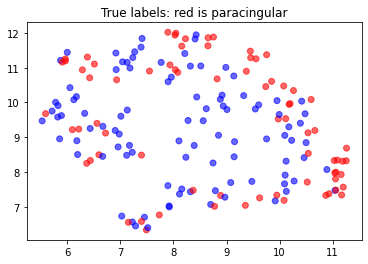

In [168]:
    ## plot the graphs
    # plot for true labels
    plt.figure()
    cmap = ['b', 'r']
    colors = [cmap[i] for i in prediction_df.label]

    plt.scatter(visual_embs[:,0], visual_embs[:,1], c=colors, alpha=0.6)
    plt.title("True labels: red is paracingular")
    plt.show()

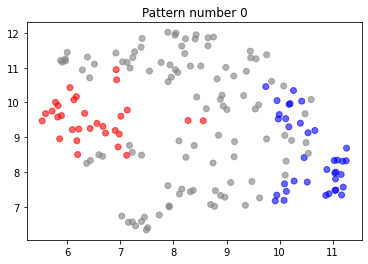

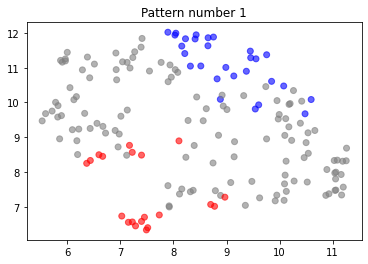

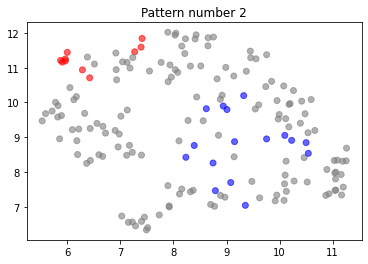

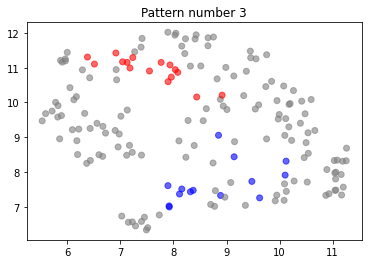

In [169]:
for i in range(4):
    visualize_umaps_with_dict(visual_embs, transformed, i, False)

In [170]:
print(transformed.shape)
print(prediction_df.label.shape)

(171, 4)
(171,)


In [185]:
def do_auc_supervised(x,y):
    y = y.copy()
    y['pred'] = x
    y = y[y.pred != 0.]
    model = SVC(kernel='linear',probability=True, max_iter=1000)
    X = y.pred.values.reshape(-1,1)
    labels_pred = model.fit(X,y.label).predict_proba(X)
    return roc_auc_score(y.label,labels_pred[:,1])

In [189]:
def do_auc_sigmoid(x,y):
    y = y.copy()
    y['pred'] = x
    y = y[y.pred != 0.]
    # We don't know which side represents the patterns=
    pred1 = 1. / (1. + np.exp(y.pred))
    auc1 = roc_auc_score(y.label,pred1)
    pred2 = 1. / (1. + np.exp(-y.pred))
    auc2 = roc_auc_score(y.label,pred2)
    return max(auc1, auc2)

In [191]:
do_auc_supervised(transformed[:,0], prediction_df[["label"]])

0.7912186379928315

In [192]:
do_auc_sigmoid(transformed[:,0], prediction_df[["label"]])

0.7912186379928315

In [213]:
latent_df = pd.read_csv(test_model+'/'+dataset+'_embeddings/full_embeddings.csv', index_col=0)
latent_df.sort_index(inplace=True)
latent_df_normalized = (latent_df - latent_df.mean()) / latent_df.std()
n_components = [1,2,4,6,8,10]
results_auc = np.zeros((len(n_components),n_components[-1]))
for i, n_component in enumerate(n_components):
    dict_learner = DictionaryLearning(n_components=n_component, transform_n_nonzero_coefs, alpha=1)
    transformed = dict_learner.fit_transform(latent_df_normalized)
    for j in range(n_component):
        results_auc[i, j] = do_auc_sigmoid(transformed[:,j], prediction_df[["label"]])
results_auc = -np.sort(-results_auc)
results_auc

array([[0.64956668, 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.66829268, 0.65296053, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.79121864, 0.7443609 , 0.6486014 , 0.64550265, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.925     , 0.85784314, 0.65789474, 0.64102564, 0.62393162,
        0.57988166, 0.        , 0.        , 0.        , 0.        ],
       [0.92      , 0.91071429, 0.82222222, 0.66      , 0.64583333,
        0.62222222, 0.6       , 0.58333333, 0.        , 0.        ],
       [0.9       , 0.88      , 0.75757576, 0.73333333, 0.71111111,
        0.65      , 0.64285714, 0.63636364, 0.61688312, 0.6       ]])

<AxesSubplot:>

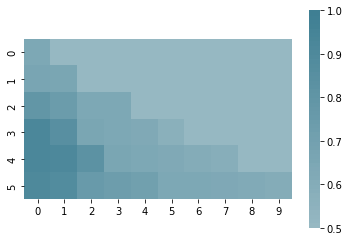

In [214]:
sns.heatmap(
        results_auc, 
        vmin=0.5, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True
        )

(10,)
(10,)


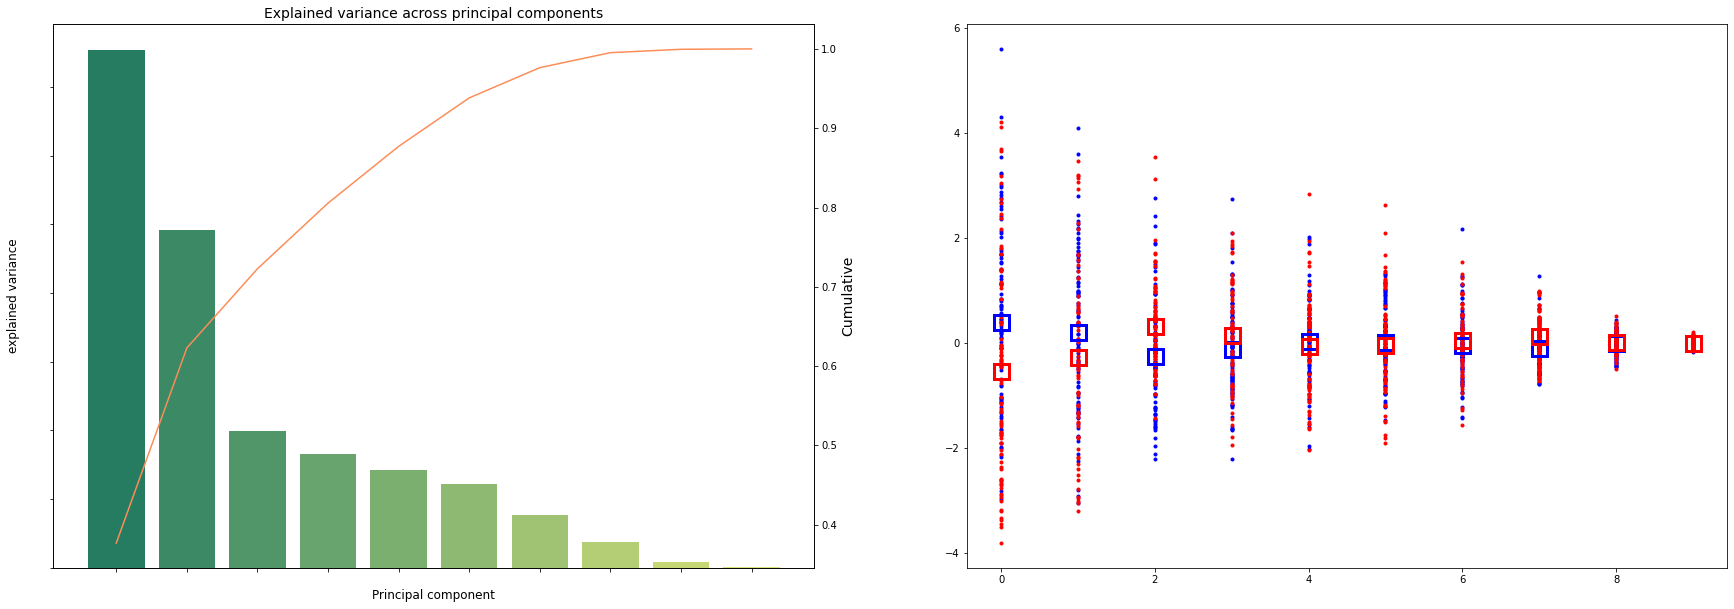

In [21]:
do_pca(test_model)

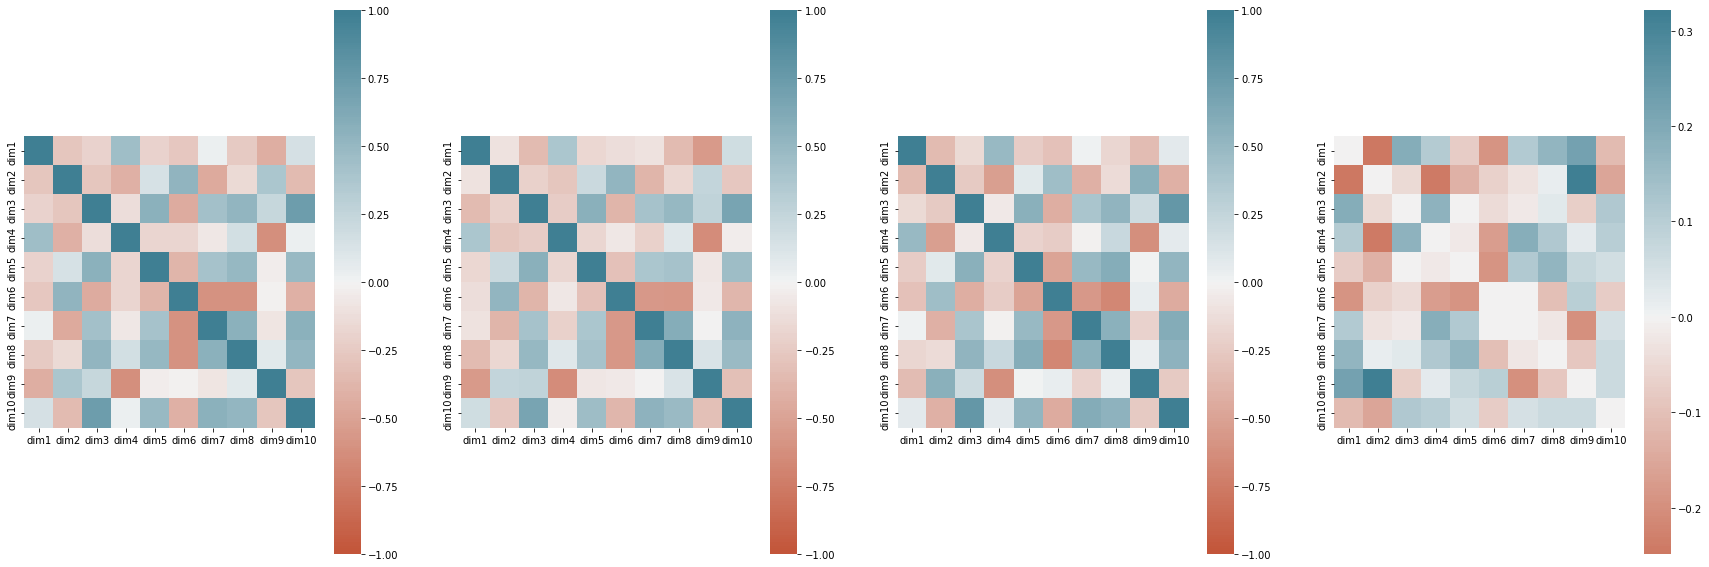

In [22]:
cross_correlation(test_model)